# Prueba desempeño 

**Parámetros de la prueba:**
* Arquitectura: Mobilenet V1 
* Datos:skin-cancer-3clases
* Data Augmentation: Yes
  * Horizontal flip : true
  * Vertical flip : true
* K-Fold Validation: sí
* Hyperparameter Tuning: No

**Parámetros estáticos de entrenamiento:**
* lr = 1e-3
* init = 'normal'
* activ = 'relu'
* activ_last = 'softmax'
* optim = 'adam'
* epochs = 20
* batch_size = 64


---


*Notas:*  

* Se reemplazo la capa flatten por GlobalAveragePooling debido a que generaba problemas en el entrenamiento.En particular elevaba considerablemente el valor de las perdidas y al ser reemplazada el modelo tuvo convergencia. Se recomienda investigar que efectos tiene GlobalAveragePooling sobre la red.
* Se implemento la funcion para el Test
* Se implemento F1 Score 
* Se implemento la matriz de confusion (normalizada)


In [3]:
# Librerias Basicas 
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os
import seaborn as sns
import itertools
from glob import glob
from PIL import Image
import PIL.Image
from IPython.display import Image
np.random.seed(11) # It's my lucky number

# Librerias de preprocesamiento y metricas
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score

# Librerias para backend, arquitectura y entrenamiento
import keras
import tensorflow as tf
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from keras.layers.core import Activation
from keras.metrics import categorical_crossentropy
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras import optimizers
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input

**Instalar los repositorios de kaggle para descargar los datos.**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir Mob_v1_3CLASES

Mounted at /content/drive


**Preprocesar y organizar los datos**

In [5]:
# identificar las rutas y los nombres de las carpetas
folder_carcinoma_train = '../content/drive/MyDrive/data_todo/Train_val/basal_cell_carcinoma_and_squamous_cell_carcinoma'
folder_melanoma_train = '../content/drive/MyDrive/data_todo/Train_val/melanoma'
folder_keratosis_train= '../content/drive/MyDrive/data_todo/Train_val/pigmented_bening_keratosis'

folder_carcinoma_test = '../content/drive/MyDrive/data_todo/Test/basal_cell_carcinoma_and_squamous_cell_carcinoma'
folder_melanoma_test = '../content/drive/MyDrive/data_todo/Test/melanoma'
folder_keratosis_test = '../content/drive/MyDrive/data_todo/Test/pigmented_bening_keratosis'

train_data_dir = '../content/drive/MyDrive/data_todo/Train_val'
test_data_dir ='../content/drive/MyDrive/data_todo/Test'


In [6]:
read = lambda imname: np.asarray(PIL.Image.open(imname).convert("RGB"))

import cv2

def resize_img(img):
  width , height = 224,224
  resize_image = []
  full_size_image = img
  resize_image.append(cv2.resize(full_size_image, (width , height), interpolation=cv2.INTER_CUBIC))
  return resize_image[0]

# cargar las imagenes de train 
ims_carcinoma = [read(os.path.join(folder_carcinoma_train, filename)) for filename in os.listdir(folder_carcinoma_train)]
X_carcinoma=[]
for img in ims_carcinoma:
  X_carcinoma.append(np.array(resize_img(img), dtype='uint8'))

#print (X_carcinoma)
ims_melanoma = [read(os.path.join(folder_melanoma_train, filename)) for filename in os.listdir(folder_melanoma_train)]
X_melanoma=[]
for img in ims_melanoma:
  X_melanoma.append(np.array(resize_img(img), dtype='uint8'))

ims_keratosis = [read(os.path.join(folder_keratosis_train, filename)) for filename in os.listdir(folder_keratosis_train)]
X_keratosis=[]
for img in ims_keratosis:
  X_keratosis.append(np.array(resize_img(img), dtype='uint8'))

In [7]:
# Cargar las imagenes de test
ims_carcinoma = [read(os.path.join(folder_carcinoma_test, filename)) for filename in os.listdir(folder_carcinoma_test)]
X_carcinoma_test=[]
for img in ims_carcinoma:
  X_carcinoma_test.append(np.array(resize_img(img), dtype='uint8'))

ims_melanoma = [read(os.path.join(folder_melanoma_test, filename)) for filename in os.listdir(folder_melanoma_test)]
X_melanoma_test=[]
for img in ims_melanoma:
  X_melanoma_test.append(np.array(resize_img(img), dtype='uint8'))

ims_keratosis = [read(os.path.join(folder_keratosis_test, filename)) for filename in os.listdir(folder_keratosis_test)]
X_keratosis_test=[]
for img in ims_keratosis:
  X_keratosis_test.append(np.array(resize_img(img), dtype='uint8'))

In [8]:
# Crear etiquetas
y_carcinoma = np.zeros(np.shape(X_carcinoma)[0])
y_melanoma = np.ones(np.shape(X_melanoma)[0])
y_keratosis = 2*np.ones(np.shape(X_keratosis)[0])

y_carcinoma_test = np.zeros(np.shape(X_carcinoma_test)[0])
y_melanoma_test = np.ones(np.shape(X_melanoma_test)[0])
y_keratosis_test = 2*np.ones(np.shape(X_keratosis_test)[0])

In [9]:
print("ENTRENAMIENTO")
print(np.shape(X_carcinoma))
print(np.shape(X_melanoma))
print(np.shape(X_keratosis))

ENTRENAMIENTO
(675, 224, 224, 3)
(1328, 224, 224, 3)
(1000, 224, 224, 3)


In [10]:
print("TEST")
print(np.shape(X_carcinoma_test))
print(np.shape(X_melanoma_test))
print(np.shape(X_keratosis_test))

TEST
(136, 224, 224, 3)
(239, 224, 224, 3)
(99, 224, 224, 3)


In [11]:
# Crear datos combinados para train y test 
X_train = np.concatenate((X_carcinoma, X_melanoma, X_keratosis), axis = 0)
y_train = np.concatenate((y_carcinoma, y_melanoma,y_keratosis), axis = 0)

X_test = np.concatenate((X_carcinoma_test, X_melanoma_test,X_keratosis_test), axis = 0)
y_test = np.concatenate((y_carcinoma_test, y_melanoma_test,y_keratosis_test), axis = 0) 

In [12]:
# Randomizar los datos
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

Graficar algunos datos para prueba (celda para opcional)

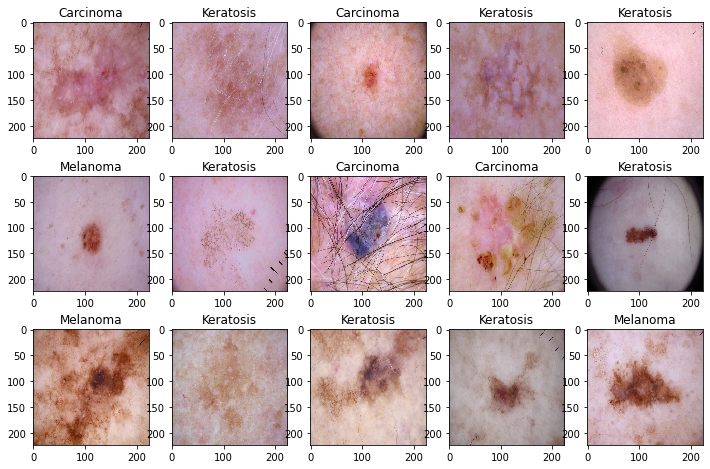

In [13]:
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Carcinoma')
    elif  y_train[i] == 1:
        ax.title.set_text('Melanoma')
    else:
        ax.title.set_text('Keratosis')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()


In [14]:

# Etiquetas a categoricas 
y_train = to_categorical(y_train, num_classes= 3)
y_test = to_categorical(y_test, num_classes= 3)

# Normalización 
X_train = X_train/255.
X_test = X_test/255.

**Crear modelo Mobilenet v1**

In [15]:
base_model=MobileNet(input_shape = (224,224,3), weights='imagenet',include_top=False) # importar mobilenet y descartar la ultima capa

x=base_model.output
#x = Flatten()(x)
x=GlobalAveragePooling2D()(x)
#x=Dense(1024,activation='relu')(x) 
#x=Dense(1024,activation='relu')(x) 
x=Dense(1024,activation='relu')(x)  
x = Dropout(0.25)(x)
preds=Dense(3,activation='softmax')(x) 

model=Model(inputs=base_model.input,outputs=preds)
Model.summary(model)




17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
______________________________________________________________

In [16]:
from keras import optimizers
input_shape = (224,224,3)
lr = 1e-3
init = 'normal'
activ = 'relu'
optim = keras.optimizers.Adam(learning_rate=lr)
epochs = 100
batch_size = 64
img_height= 224
img_width = 224

train_datagen = ImageDataGenerator(
        rescale=1./255,
        #shear_range=0.2,
        #zoom_range=0.1,
        horizontal_flip=True,
        #zoom_range=[0.5,0.5],
        vertical_flip=True,
        validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
                                                    train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training') 

validation_generator = train_datagen.flow_from_directory(
                                                        train_data_dir, # same directory as training data
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        subset='validation' # set as validation data
                                                        )


data_train,label_train=train_generator[0]
data_valid,label_valid=validation_generator[0]
#data_test,label_test=test_generador[0]
print("Data_train len:",len(data_train),"label_valid len:",len(label_train))
print("data_valid len:",len(data_valid),"label_valid len:",len(label_valid))
#print("Data_test len:",len(data_test),"label_test len:", len(label_test))




decay_rate = 0;
momentum = 0.8;


# ALMACENADORES PARA CADA FOLD
acc_per_fold = []
loss_per_fold = []
# UNIMOS VALID Y TEST SET

inputs = np.concatenate((data_train, data_valid), axis=0)
targets = np.concatenate((label_train, label_valid), axis=0)

# In[train]
# DEFINIMOS EL K-FLOD CROSS VALIDATOR Y NUMERO DE FOLDS
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-FOLD CROSS VALIDATION
fold_no = 1
for layer in base_model.layers:
        layer.trainable = False

for train, test in kfold.split(inputs, targets):
    if fold_no == 1:
    # GENERAR EL MODELO DE LA RED Y COMPILARLO
    
        input_shape = train.shape
        
    ## INGRESE AQUI SU MODELO ---------------------------------------------------------------------------------
        model=Model(inputs=base_model.input,outputs=preds)
    ## TERMINA EL ESPACIO PARA EL MODELO ----------------------------------------------------------------------
    
    
        
   
    
    rmsprop = optimizers.RMSprop(lr=lr, rho=0.9, epsilon=None, decay=decay_rate)
    sgd = optimizers.SGD(lr=lr, momentum=momentum, decay=decay_rate, nesterov=False)
    adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay_rate)

    


    # GENERAR EL REPORTE 
    print('------------------------------------------------------------------------')
    print('ENTRENAMIENTO PARA EL FOLD: ',fold_no)



    # REALIZAR EL ENTRENAMIENTO Y GRAFICAR RESULTADOS
    

    model.compile(optimizer = optim ,loss = "categorical_crossentropy", metrics=["accuracy"])

    
    #checkpoint_filepath = '../content/Mob_v1_3CLASES/best_Model_3class_v5.h5'

    callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=20,),
   
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.1, 
        patience=4,
        verbose=1,  
         min_lr=1e-12),

    keras.callbacks.ModelCheckpoint(
        filepath='model_mobilenetv1_3_clases.h5', 
        save_weights_only=True,
        monitor='val_accuracy',
        mode = 'max',
        verbose=1, 
        save_best_only=True)
  ]         

    history= model.fit(train_generator, steps_per_epoch=2403/batch_size, epochs=epochs, 
                              validation_data=validation_generator, validation_steps=600/batch_size, verbose=1,
                              callbacks=callbacks_list)

   
    # GENERAR METRICAS DE GENERALIZACIÓN
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print('METRICAS PARA EL FOLD: ',fold_no,': ',model.metrics_names[0],' of ',scores[0],'; ',model.metrics_names[1],' of ',scores[1]*100,'%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no = fold_no + 1

# GENERAR METRICAS GENERALES
    print('------------------------------------------------------------------------')
    print('METRICAS POR FOLD')
    for i in range(0, len(acc_per_fold)):
        print('------------------------------------------------------------------------')
        print('> Fold ',i+1,' - Loss: ',loss_per_fold[i],' - Accuracy: ',acc_per_fold[i],'%')
    print('------------------------------------------------------------------------')
    print('METRICAS EN PROMEDIO K-FOLD CROSSVALIDATION:')
    print('> Accuracy: ',np.mean(acc_per_fold),' (+- ',np.std(acc_per_fold),')')
    print('> Loss: ',np.mean(loss_per_fold),'}')
    print('------------------------------------------------------------------------')


Found 2403 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Data_train len: 64 label_valid len: 64
data_valid len: 64 label_valid len: 64
------------------------------------------------------------------------
ENTRENAMIENTO PARA EL FOLD:  1
Epoch 1/100
37/37 [==============================] - 44s 967ms/step - loss: 1.3457 - accuracy: 0.4953 - val_loss: 0.7861 - val_accuracy: 0.6283

Epoch 00001: val_accuracy improved from -inf to 0.62833, saving model to model_mobilenetv1_3_clases.h5
Epoch 2/100
37/37 [==============================] - 33s 886ms/step - loss: 0.6174 - accuracy: 0.7318 - val_loss: 0.7463 - val_accuracy: 0.6600

Epoch 00002: val_accuracy improved from 0.62833 to 0.66000, saving model to model_mobilenetv1_3_clases.h5
Epoch 3/100
37/37 [==============================] - 33s 881ms/step - loss: 0.5312 - accuracy: 0.7871 - val_loss: 0.7059 - val_accuracy: 0.6767

Epoch 00003: val_accuracy improved from 0.66000 to 0.67667, saving model to model_mobilenet

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
model.save("model_mobilenetv1_3_clases.h5")
print("Saved model to disk")

Saved model to disk


In [19]:
#conversion a tlfite
from keras.models import load_model
from tensorflow.keras import layers
import tensorflow_hub as hub
reload = tf.keras.models.load_model('/content/model_mobilenetv1_3_clases.h5', custom_objects={'KerasLayer': hub.KerasLayer},compile=False)
converter = tf.lite.TFLiteConverter.from_keras_model(reload)
tflite_model = converter.convert()
open("/content/model_mobilenetv1_3_clases_conv.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp29xjxkri/assets


17011292

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


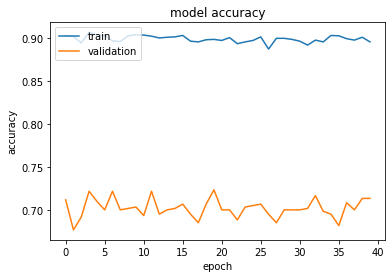

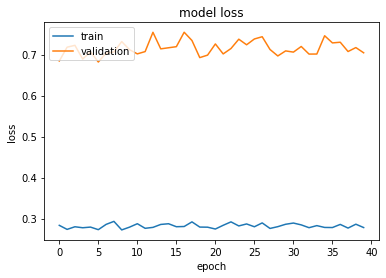

In [20]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
##plot confusion matrix
! pip install mlxtend

In [22]:
model.load_weights('/content/model_mobilenetv1_3_clases.h5')

In [23]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [24]:
cm = confusion_matrix(y_true=test_labels, y_pred=rounded_predictions)

NameError: ignored

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [ ]:
cm_plot_labels = ['no_side_effects','had_side_effects']

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
#pasar todas las imágenes de validación a array  PARA LA MATRIZ DE CONFUSIÓN
val_all_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
val_all_data_gen = val_all_image_generator.flow_from_directory(batch_size=180,
                                                           directory=val_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE, IMG_SHAPE),
                                                           class_mode='sparse')


**Test Modelo y Evaluación del desempeño**

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./ 255)
test_generator = test_datagen.flow_from_directory(
                                                    test_data_dir,  
                                                    target_size=(img_height,img_width), 
                                                    batch_size=batch_size,  
                                                    class_mode='categorical',
                                                    shuffle=False
                                                  )


model.load_weights('model_mobilenetv1_3_clases.h5')
model.evaluate(test_generator, batch_size=128)

import sklearn
from sklearn.metrics import f1_score
y_pred = model.predict(X_test)
y_pred = np.fix(y_pred+0.5)
print('F1 score = ',f1_score(y_test, y_pred, average='weighted'))

def get_confusion_matrix(y_true, y_pred, normalized):
    y_pred = np.where(y_pred)
    label_test = y_pred[1]
    y_test = np.where(y_true)
    index = y_test[1]
    n_classes = len(np.unique(y_true))
    M = np.zeros((n_classes, n_classes))
    cont = 0
    for n in range(0,len(index)):
        M[label_test[n]][index[n]] = M[label_test[n]][index[n]]+1
        cont = cont+1
    M.astype('int')
    if normalized == True:
        conf = np.transpose( np.transpose(M)/np.sum(M,axis=1) )
    return conf

conf = get_confusion_matrix(y_test, y_pred, True)
print('Confusion matrix = ')
print(conf)

P = conf.sum(axis=0)
R =  conf.sum(axis=1)
D = R+P
F1i = 2*np.diag(conf)/D
print('F1i Score = ')
print(F1i)

In [ ]:
plt.plot(history.history['lr'])